In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda



Train set Size: 2170
Val set Size: 620
Test set Size: 311

Train set class distribution:
label
0    297
1    845
2    666
3    362
Name: count, dtype: int64
\Val set class distribution:
label
0     85
1    241
2    191
3    103
Name: count, dtype: int64
\Test set class distribution:
label
0     43
1    121
2     95
3     52
Name: count, dtype: int64

Epoch 1/100
------------------------------
✅ Validation loss decrease. Ynew best model saved.
Train Loss: 1.3533 Acc: 0.3433
Val   Loss: 1.2926 Acc: 0.4065
Learning Rate: 0.000030

Epoch 2/100
------------------------------
✅ Validation loss decrease. Ynew best model saved.
Train Loss: 1.3002 Acc: 0.4194
Val   Loss: 1.2674 Acc: 0.4258
Learning Rate: 0.000030

Epoch 3/100
------------------------------
✅ Validation loss decrease. Ynew best model saved.
Train Loss: 1.2823 Acc: 0.4171
Val   Loss: 1.2449 Acc: 0.4452
Learning Rate: 0.000030

Epoch 4/100
------------------------------
✅ Validation loss decrease. Ynew best model saved.
Train Los

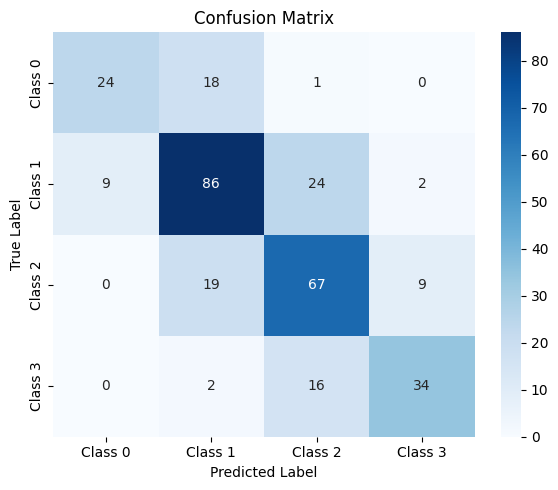


📊 Final Train Accuracy: 0.7184
📊 Final Val Accuracy:   0.6984


In [ ]:
# --------------------------
# 1. Kütüphaneler
# --------------------------
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import timm
import time
import copy


BASE_PATH = "/kaggle/input/mamogram"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def load_dataframe(base_path):
    folders = [("data1/1", 0), ("data2/2", 1), ("data3/3", 2), ("data4/4", 3)]
    data = []
    for folder, label in folders:
        folder_path = os.path.join(base_path, folder)
        for fname in os.listdir(folder_path):
            if fname.lower().endswith((".png", ".jpg", ".jpeg")):
                data.append({"filepath": os.path.join(folder_path, fname), "label": label})
    df = pd.DataFrame(data).sample(frac=1, random_state=42).reset_index(drop=True)
    return df

df = load_dataframe(BASE_PATH)

train_df, temp_df = train_test_split(df, train_size=0.7, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, train_size=2/3, stratify=temp_df['label'], random_state=42)

print("\nTrain set Size:", len(train_df))
print("Val set Size:", len(val_df))
print("Test set Size:", len(test_df))

print("\nTrain set class distribution:")
print(train_df['label'].value_counts().sort_index())
print("\Val set class distribution:")
print(val_df['label'].value_counts().sort_index())
print("\Test set class distribution:")
print(test_df['label'].value_counts().sort_index())


from torchvision.transforms import functional as F
import torchvision.transforms as T
"""
class CustomAugmentations:
    def __init__(self):
        self.affine = T.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=5)
        #self.perspective = T.RandomPerspective(distortion_scale=0.2, p=0.3)
        self.to_tensor = T.ToTensor()
        self.normalize = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        self.erasing = T.RandomErasing(p=0.3, scale=(0.02, 0.2))

    def __call__(self, img):
        img = self.affine(img)
        #img = self.perspective(img)
        img = self.to_tensor(img)
        img = self.normalize(img)
        img = self.erasing(img)
        return img

train_transforms = CustomAugmentations()
"""
class CustomAugmentations:
    def __init__(self):
        self.transforms = T.Compose([
            T.Resize((224, 224)),  # Optional: Resize input
            T.RandomHorizontalFlip(p=0.5),
            T.RandomVerticalFlip(p=0.5),
            T.RandomAffine(
                degrees=90,
                translate=(0.2, 0.2),
                scale=(0.8, 1.2),
                shear=11.5  # 0.2 * 57.3 degrees
            ),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], 
                        [0.229, 0.224, 0.225]),
            T.RandomErasing(p=0.3, scale=(0.02, 0.2))
        ])

    def __call__(self, img):
        return self.transforms(img)
        
train_transforms = CustomAugmentations()       
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


class BreastDensityDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['filepath']
        label = int(self.dataframe.iloc[idx]['label'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

train_dataset = BreastDensityDataset(train_df, transform=train_transforms)
val_dataset = BreastDensityDataset(val_df, transform=val_test_transforms)
test_dataset = BreastDensityDataset(test_df, transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


model = timm.create_model('convnext_tiny.fb_in1k', pretrained=True)

model.head = nn.Sequential(
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(model.head.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5), #0.5
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5), #0.5
    nn.Linear(256, 4)
)

model = model.to(device)

for param in model.parameters():
    param.requires_grad = False
for param in model.head.parameters():
    param.requires_grad = True


criterion = nn.CrossEntropyLoss(label_smoothing=0.1) #0.1
optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)  #3e-5
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5, #0.5
    patience=3,
    min_lr=1e-6
)


def train_model(model, criterion, optimizer, scheduler, num_epochs=100, patience=10, unfreeze_epoch=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        if epoch == unfreeze_epoch:
            print("🔓 Fine-tuning start: All layes are trained.")
            for param in model.parameters():
                param.requires_grad = True

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            dataloader = train_loader if phase == 'train' else val_loader
            running_loss, running_corrects = 0.0, 0

            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    if outputs.dim() == 4:
                        outputs = outputs.mean(dim=[2, 3])
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)
                scheduler.step(epoch_loss)

                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                    print("✅ Validation loss decrease. Ynew best model saved.")
                else:
                    epochs_no_improve += 1
                    print(f"⏸ No improvement in validation loss for {epochs_no_improve} epochs.")

        current_lr = optimizer.param_groups[0]['lr']
        print(f'Train Loss: {train_losses[-1]:.4f} Acc: {train_accuracies[-1]:.4f}')
        print(f'Val   Loss: {val_losses[-1]:.4f} Acc: {val_accuracies[-1]:.4f}')
        print(f'Learning Rate: {current_lr:.6f}')

        if epochs_no_improve >= patience:
            print(f"\n⛔ Early stopping: {patience} epochs boyunca gelişme yok.")
            break

    time_elapsed = time.time() - since
    print(f'\n⏱ Eğitim süresi: {time_elapsed // 60:.0f} dk {time_elapsed % 60:.0f} sn')
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accuracies, val_accuracies


def evaluate_model_with_metrics(model, dataloader, criterion, class_names=None):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if outputs.dim() == 4:
                outputs = outputs.mean(dim=[2, 3])
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    total_loss = running_loss / len(dataloader.dataset)
    total_acc = running_corrects.double() / len(dataloader.dataset)
    print(f"\nTest Loss: {total_loss:.4f}")
    print(f"Test Accuracy: {total_acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names if class_names else None))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


model, train_losses, val_losses, train_accs, val_accs = train_model(
    model,
    criterion,
    optimizer,
    scheduler,
    num_epochs=100,
    patience=10,
    unfreeze_epoch=15
)


class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']
evaluate_model_with_metrics(model, test_loader, criterion, class_names=class_names)

print("\n📊 Final Train Accuracy: {:.4f}".format(train_accs[-1]))
print("📊 Final Val Accuracy:   {:.4f}".format(val_accs[-1]))

In [7]:
def compute_accuracy(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if outputs.dim() == 4:
                outputs = outputs.mean(dim=[2, 3])
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

    acc = running_corrects.double() / total_samples
    avg_loss = running_loss / total_samples
    return avg_loss, acc

def compute_accuracy2(model, dataloader, criterion):
    model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if outputs.dim() == 4:
                outputs = outputs.mean(dim=[2, 3])
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            total_correct += torch.sum(preds == labels).item()
            total_samples += labels.size(0)
            total_loss += loss.item() * labels.size(0)

    return total_loss / total_samples, total_correct / total_samples

train_loss, train_acc = compute_accuracy2(model, train_loader, criterion)
val_loss, val_acc = compute_accuracy2(model, val_loader, criterion)

print(f"\n📈 General Train Accuracy: {train_acc:.4f} | Loss: {train_loss:.4f}")
print(f"📈 General Val   Accuracy: {val_acc:.4f} | Loss: {val_loss:.4f}")



📈 General Train Accuracy: 0.7230 | Loss: 0.8289
📈 General Val   Accuracy: 0.7032 | Loss: 0.8584


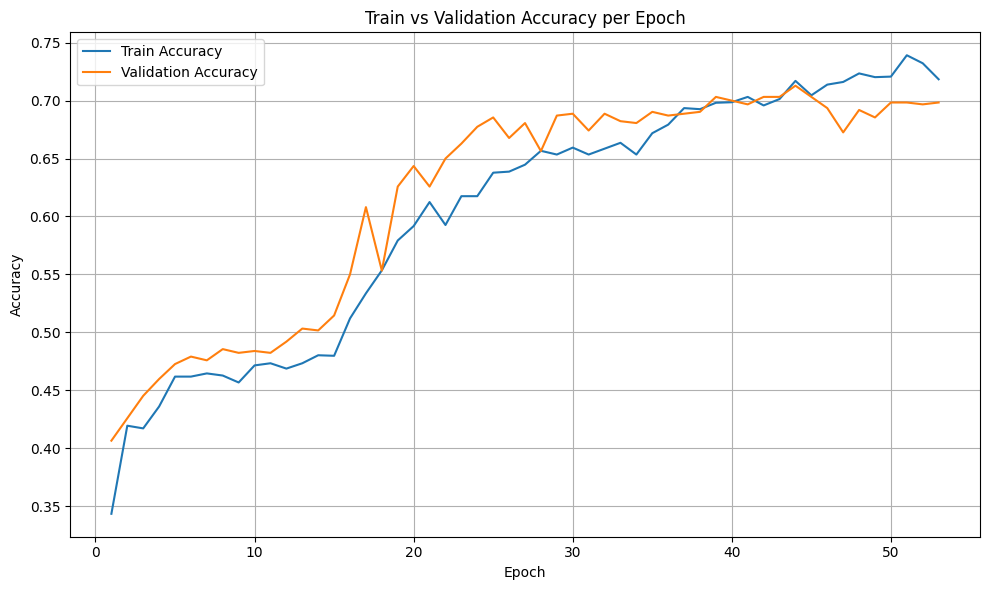

In [8]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_accs) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, [acc.cpu().item() for acc in train_accs], label='Train Accuracy')
plt.plot(epochs, [acc.cpu().item() for acc in val_accs], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()